# Исследование AB-тестирования нового алгоритма рекомендаций в развлекательном приложении


- Автор: Егорова Ольга

Компания разрабатывает развлекательное приложение с функцией «бесконечной» ленты. В приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

# Описание данных

В распоряжении имеется 3 таблицы:

- **Таблица `sessions_project_history.csv`** — с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. 
- **Таблица `sessions_project_test_part.csv`** — с данными за первый день проведения A/B-теста, то есть за 2025-10-14.
- **Таблица  `sessions_project_test.csv`** — с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. 


Структура и содержание полей совпадают, различаются лишь периоды наблюдения.

**Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:**

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).

# Задачи:
- рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

# План работы:
1. Работа с историческими данными (EDA)
2. Мониторинг А\В-теста
3. Проверка результатов А\В-теста

## Работа с историческими данными (EDA)

### Загрузка и знакомство с историческими данными

In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt

# для математических расчетов: округление и модуль
from math import ceil, fabs

# для расчета размера выборки
from statsmodels.stats.power import NormalIndPower

# для z-теста пропорций, расчета эффекта и мощности
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.power import zt_ind_solve_power

# χ²-тест на гомогенность
from scipy.stats import chisquare

# χ²-тест на независимость двух категориальных переменных
from scipy.stats import chi2_contingency

* Загружаем в `sessions_history` csv-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`:

In [4]:
# Загружаем данные
url_1 = 'https://drive.google.com/uc?export=download&id=1-cwY5JJciNUoJicfIKcm-P1U0UadkndU'
sessions_history = pd.read_csv(url_1)

* Посмотрим краткую сводку о датафрейме `sessions_history`:

In [5]:
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


Данные не содержат пропусков. Некоторые столбцы имеют некорректный тип данных, например, столбцы с датами имеют тип `object`, однако в рамках проекта работа с датами не подразумевается, поэтому типы преобразовывать не будем.

* Проверим корректность числовых данных в столбцах `session_number`, `registration_flag`, `page_counter`:

In [6]:
sessions_history.describe()

,session_number,registration_flag,page_counter
count,435924.000000,435924.000000,435924.000000
mean,2.382908,0.077325,3.005561
std,1.288487,0.267107,1.024625
min,1.000000,0.000000,1.000000
25%,1.000000,0.000000,2.000000
50%,2.000000,0.000000,3.000000
75%,3.000000,0.000000,4.000000
max,10.000000,1.000000,7.000000


Никаких аномалий не наблюдается.

* Проверим количество уникальных значений в каждом столбце таблицы:

In [7]:
sessions_history.nunique()

user_id              134039
session_id           435924
session_date             44
session_start_ts     373059
install_date             31
session_number           10
registration_flag         2
page_counter              7
region                    3
device                    4
dtype: int64

Единственное поле с уникальными значениями по всей таблице - это идентификаторы сессий `session_id`.

* Посмотрим пользователи каких регионов `region` присутствуют в данных и какими типами устройств `device` они пользуются:

In [8]:
region_name = sessions_history['region'].unique()
device_type = sessions_history['device'].unique()

print('Регионы:', list(region_name))
print('Устройства:', list(device_type))

Регионы: ['CIS', 'MENA', 'EU']
Устройства: ['iPhone', 'Android', 'PC', 'Mac']


* Выведем все поля таблицы `sessions_history` на примере пользователя с наибольшим количеством сессий. Для этого воспользуемся комбинацией методов `.value_counts().idxmax()`:

In [9]:
# Выводим данные одного пользователя
sessions_history[sessions_history['user_id'] == sessions_history['user_id'].value_counts().idxmax()]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
124515,6A73CB5566BB494D,110E3F28C1F5415F,2025-08-28,2025-08-28 18:58:19,2025-08-28,1,0,3,MENA,Mac
196252,6A73CB5566BB494D,D68C8D98A0F1C439,2025-08-29,2025-08-29 20:53:27,2025-08-28,2,1,3,MENA,Mac
242428,6A73CB5566BB494D,6587D217472BF807,2025-08-30,2025-08-30 13:08:22,2025-08-28,3,1,1,MENA,Mac
304287,6A73CB5566BB494D,A9BC25593D056F8E,2025-09-01,2025-09-01 18:52:49,2025-08-28,4,1,2,MENA,Mac
346611,6A73CB5566BB494D,CB6F9C4191FAF6F6,2025-09-03,2025-09-03 22:49:08,2025-08-28,5,1,3,MENA,Mac
363510,6A73CB5566BB494D,9C609432F6E6535A,2025-09-04,2025-09-04 13:59:46,2025-08-28,6,1,4,MENA,Mac
391902,6A73CB5566BB494D,5D892E33B97A257A,2025-09-06,2025-09-06 18:46:55,2025-08-28,7,1,2,MENA,Mac
404322,6A73CB5566BB494D,22A9BD3861F49087,2025-09-07,2025-09-07 18:33:49,2025-08-28,8,1,3,MENA,Mac
415489,6A73CB5566BB494D,F70E351154B092DC,2025-09-08,2025-09-08 20:30:22,2025-08-28,9,1,4,MENA,Mac
425805,6A73CB5566BB494D,84A3DC0CFF449F53,2025-09-09,2025-09-09 16:36:04,2025-08-28,10,1,1,MENA,Mac


Сразу возникает вопрос, а может ли у пользователя быть несколько сессий в один день? И может ли у пользователя измениться регион или тип устройства?

* Проверим, есть ли пользователи с количеством сессий в день больше 1. Для этого сгруппируем данные по `user_id` и `session_date` и найдем количество сессий. Далее найдем сумму истинных значений, если число сессий > 1: 

In [10]:
# Группируем и агрегируем данные
# Проверяем условие и подсчитываем истинные значения
(sessions_history.groupby(['user_id', 'session_date']).agg({'session_id':'count'}) > 1).sum()

session_id    0
dtype: int64

* Также проверим, есть ли пользователи с несколькими регионами и типами устройств:

In [11]:
# Группируем и агрегируем данные, проверяем условие и подсчитываем истинные значения
(sessions_history.groupby(['user_id']).agg({'region':'nunique'}) > 1).sum()

region    0
dtype: int64

In [12]:
# Группируем и агрегируем данные, проверяем условие и подсчитываем истинные значения
(sessions_history.groupby(['user_id']).agg({'device':'nunique'}) > 1).sum()

device    0
dtype: int64

За указанный период пользователи не меняли регион и тип устройства. Кроме того, они имеют по 1 сессии в день, значит статус регистрации в течение одного дня меняться не может.

### Исследовательский анализ исторических данных

#### Анализ числа регистраций
Одна из важнейших метрик продукта — это число зарегистрированных пользователей. Посмотрим, как менялось число регистраций в приложении за время его существования.

* Сгруппируем таблицу `sessions_history` по полю `session_date`. Для каждого дня посчитаем количество уникальных пользователей с помощью `nunique` по полю `user_id` и количество зарегистрированных пользователей как сумму `sum` по полю `registration_flag`. Переименуем названия столбцов, чтобы они соответствовали содержащейся в них информации:

In [13]:
# Группируем и агрегируем
sessions_history_users = sessions_history.groupby('session_date').agg({'user_id':'nunique', 'registration_flag':'sum'})

# Переименовываем столбцы
sessions_history_users.columns = ['total_users', 'registered_users']

In [14]:
# Посмотрим на данные
sessions_history_users

,total_users,registered_users
session_date,,
2025-08-11,3919,169
2025-08-12,6056,336
2025-08-13,8489,464
2025-08-14,10321,625
2025-08-15,14065,840
2025-08-16,12205,916
2025-08-17,11200,833
2025-08-18,10839,860
2025-08-19,12118,831


* Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням:

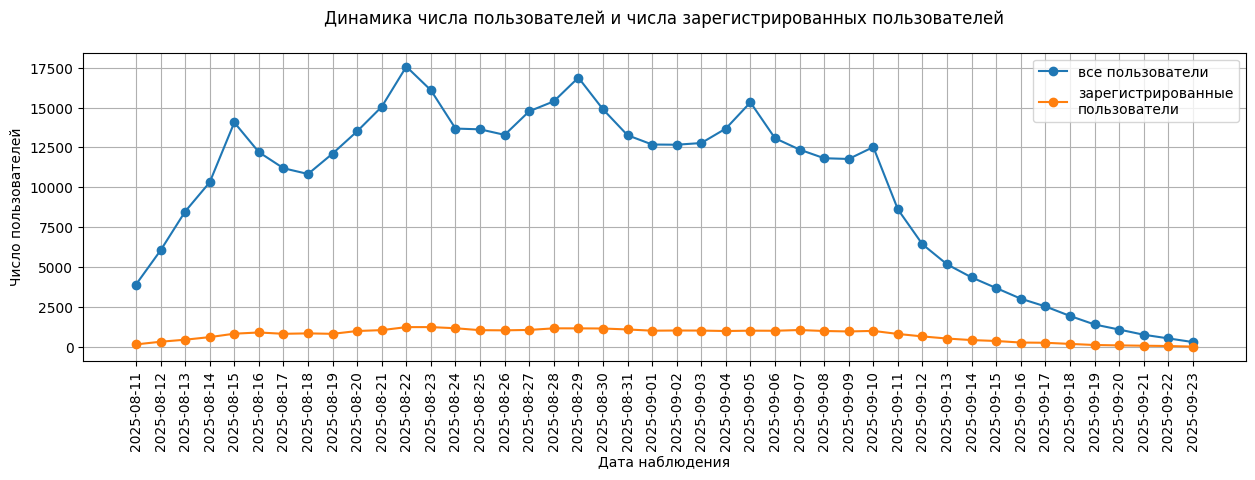

In [15]:
# Задаем размер фигуры
plt.figure(figsize=(15,4))

# Строим линейный график
plt.plot(sessions_history_users, marker='o', label=['все пользователи', 'зарегистрированные\nпользователи'])

# Отображаем легенду
plt.legend()

# Настраиваем название и подписи осей
plt.title('Динамика числа пользователей и числа зарегистрированных пользователей\n')
plt.xlabel('Дата наблюдения')
plt.ylabel('Число пользователей')

# Устанавливаем поворот для меток тиков
plt.xticks(rotation=90)

# Добавляем сетку
plt.grid()

# Отображаем график
plt.show()

Пользователи приложения ведут себя нестабильно, наблюдаются периодические пики активности:
   - первые 4 пика приходятся на пятницы (имеют интервал в 1 неделю);
   - последний пик был достигнут раньше - не через 7 дней, а уже на 5. Вероятно пользователи, как и прежде, ожидали бонуса, но, не получив его стали уходить, из-за чего активность пошла на спад. В результате всего за два дня аудитория сократилась почти на 6000 человек.  
К концу рассматриваемого периода активность существенно падает, опускаясь значительно ниже начальных значений. Снижение происходит постепенно на протяжении последниъ 1.5 недель. "Кривая всех пользователей" плавно приближается к "кривой зарегистрированных" и в конце периода они находятся максимально близко друг к другу, что вероятно говорит о потере интереса и снижении активности значительной части незарегистрированных пользователей.

Поведение зарегистрированных пользователей в наблюдаемый период более стабильно. Также наблюдается увеличение их активности, однако без ярковыраженных скачков.

Можно сделать вывод, что внешние факторы оказывают заметное воздействие на пользовательскую активность, особенно среди незарегистрированных посетителей.

* Построим линейный график доли зарегистрированных пользователей от всех пользователей по дням. Для этого подготовим данные и посчитаем долю зарегистрированных пользователей. Результат запишем в столбец `share`:

In [16]:
# Создаем новых столбец с долей
sessions_history_users['share'] = sessions_history_users['registered_users'] / sessions_history_users['total_users']

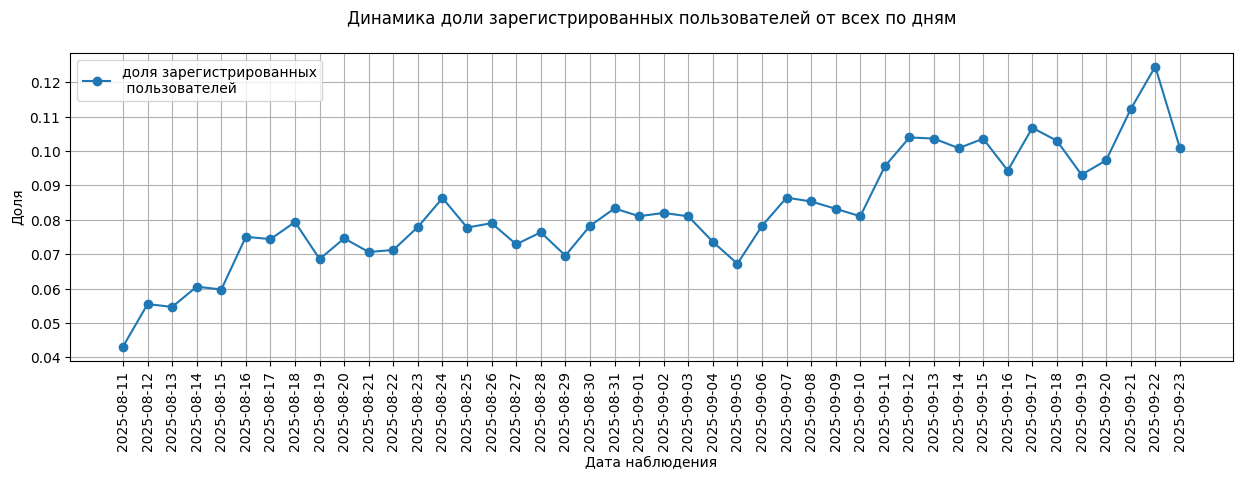

In [17]:
# Задаем размер фигуры
plt.figure(figsize=(15,4))

# Строим линейный график
plt.plot(sessions_history_users['share'], marker='o', label='доля зарегистрированных\n пользователей')

# Отображаем легенду
plt.legend()

# Настраиваем название и подписи осей
plt.title('Динамика доли зарегистрированных пользователей от всех по дням\n')
plt.xlabel('Дата наблюдения')
plt.ylabel('Доля')


# Устанавливаем поворот для меток тиков
plt.xticks(rotation=90)

# Добавляем сетку
plt.grid()

# Отображаем график
plt.show()

За рассматриваемый период доля зарегистрированных пользователей демонстрирует устойчивый рост, увеличившись с начальных 4% до 10% к концу наблюдений.

#### Анализ числа просмотренных страниц
Число просмотренных страниц в приложении - это также важная метрика продукта. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

* Посмотрим как часто пользователи просматривали определенное количество страниц за одну сессию. Для этого найдем количество сессий для каждого значения количества просмотренных страниц, сгруппируем таблицу `sessions_history` по полю `page_counter` и с помощью `count` посчитаем количество сессий `session_id`:

In [18]:
# Группируем и агрегиуем данные
sessions_history_page_counter = sessions_history.groupby('page_counter').agg({'session_id':'count'})
# Выводим результат
sessions_history_page_counter

,session_id
page_counter,
1,29160
2,105536
3,166690
4,105569
5,26288
6,2589
7,92


*  Построим столбчатую диаграмму с распределение сессий по количеству просмотренных страниц:

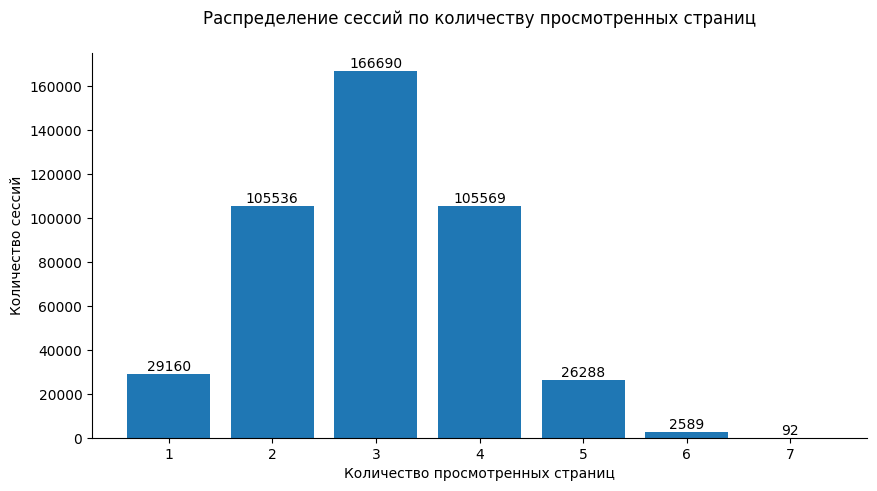

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

# Строим столбчатую диаграмму
ax.bar(sessions_history_page_counter.index, sessions_history_page_counter['session_id'])

# Задаем название и подписываем оси
ax.set_title('Распределение сессий по количеству просмотренных страниц\n')
ax.set_xlabel('Количество просмотренных страниц')
ax.set_ylabel('Количество сессий')

# Подписываем бары
plt.bar_label(ax.containers[0])

# Убираем границы
ax.spines[['top', 'right']].set_visible(False)

# Отображаем график
plt.show()

Наиболее распространенные сессий - это сессии с просмотром 3 страниц (166 690 сессий), а также сессии с просмотром 2 (105 536) и 4 страниц (105 569).  
С увеличением числа просмотренных страниц (от 4 и более) количество сессий резко снижается:
5 страниц — 26 288 сессий, 6 страниц — 2 589 сессий, 7 страниц — 92 сессии.

График демонстрирует, что поведение пользователей чаще всего ограничивается взаимодействием с приложением в рамках не более 4 страниц. Это может указывать на то, что либо контент быстро удовлетворяет их запросы, либо приложение не удерживает внимание пользователей дольше.

#### Доля пользователей, просмотревших четыре и более страниц
Важной прокси-метрикой для продукта является доля сессии, в рамках которых пользователь просмотрел 4 и более страниц, что говорит об удовлетворённости контентом и алгоритмами рекомендаций..

* В датафрейме `sessions_history` создадим дополнительный столбец `good_session`, который покажет, успешна или нет сессия.   Пусть в столбец войдет значение 1, если за одну сессию было просмотрено 4 и более страниц, и значение 0, если было просмотрено меньше:

In [20]:
# Создаем дубликат столбца 'page_counter'
sessions_history['good_session'] = sessions_history['page_counter']

# Применяем к столбцу метод .mask() и заменяем значения в нем на 0 или 1 при выполнении определенных условий
sessions_history['good_session'] = sessions_history['good_session'].mask(sessions_history['good_session']<4, 0)
sessions_history['good_session'] = sessions_history['good_session'].mask(sessions_history['good_session']>=4, 1)

* Рассчитаем для каждого дня наблюдения количество всех сессий, количество успешных сессий и долю успешных сессий. Для этого сгруппируем таблицу `sessions_history` по полю `session_date` и произведем рассчеты:

In [21]:
# Группируем и агрегируем даные
sessions_history_good_total = sessions_history.groupby('session_date', as_index=False).agg({'good_session':'sum', 'session_id':'count'})

# Переименуем столбец 'session_id' в 'session_total'
sessions_history_good_total = sessions_history_good_total.rename(columns = {'session_id': 'session_total'})

# Создадим дополнительный столбец с долей успешных сессий
sessions_history_good_total['share_good_session'] = sessions_history_good_total['good_session'] / sessions_history_good_total['session_total']

# Посмотрим на получившиеся данные
sessions_history_good_total

,session_date,good_session,session_total,share_good_session
0,2025-08-11,1226,3919,0.312835
1,2025-08-12,1829,6056,0.302015
2,2025-08-13,2604,8489,0.306750
3,2025-08-14,3262,10321,0.316055
4,2025-08-15,4289,14065,0.304941
5,2025-08-16,3737,12205,0.306186
6,2025-08-17,3557,11200,0.317589
7,2025-08-18,3366,10839,0.310545
8,2025-08-19,3791,12118,0.312840
9,2025-08-20,4148,13514,0.306941


* Данные подготовлены, теперь построим линейный график доли успешных сессий по дням:

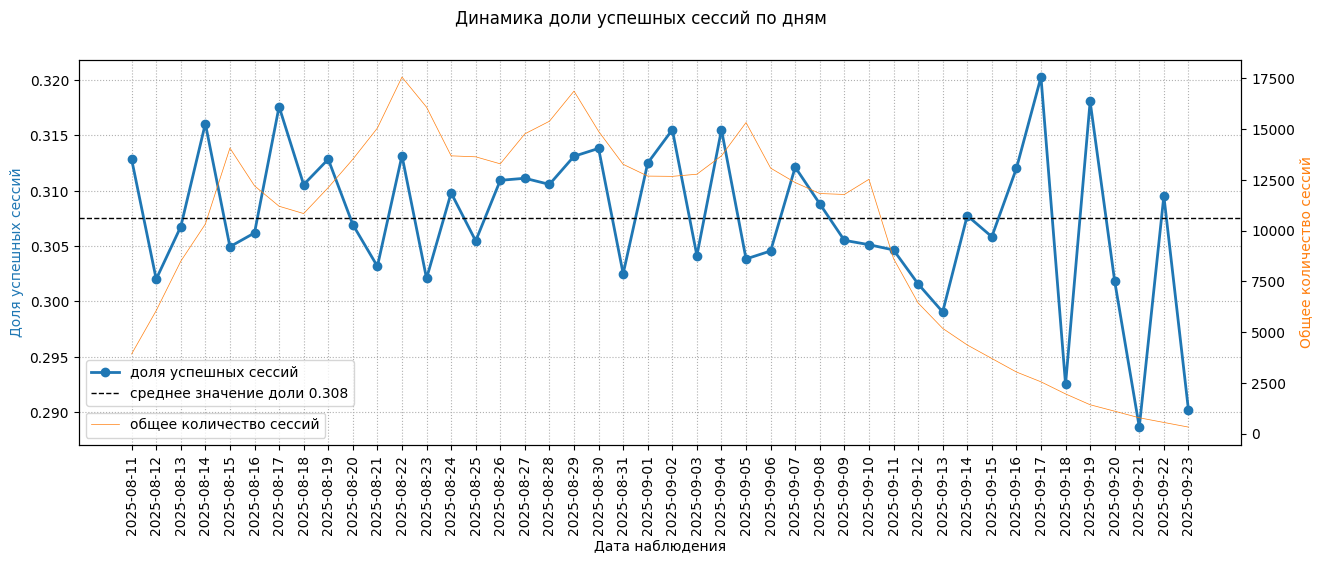

In [22]:
fig, ax1 = plt.subplots(figsize=(15,5))

# Первая ось Y
# Строим линейный график
ax1.plot(sessions_history_good_total['share_good_session'],
         marker='o', color='tab:blue', linewidth=2,
         label='доля успешных сессий')

# Добавление дополнительной оси Y 
ax2 = ax1.twinx()
ax2.plot(sessions_history_good_total['session_total'],
         color='tab:orange', linewidth=0.5,
         label='общее количество сессий')


# Отображаем среднее значение доли
# Среднее значение
avg_share = sessions_history_good_total['share_good_session'].mean()
# Наносим на график линию с долей
ax1.axhline(avg_share, color='black',
            linestyle='--', linewidth=1, 
            label=f'среднее значение доли {round(avg_share, 3)}')

# Отображаем легенды
ax1.legend(loc=(0.006, 0.1))
ax2.legend(loc=3)

# Настраиваем название и подписи осей
plt.suptitle('Динамика доли успешных сессий по дням\n')
ax1.set_xlabel('Дата наблюдения')
ax1.set_ylabel('Доля успешных сессий', color='tab:blue')
ax2.set_ylabel('Общее количество сессий', color='tab:orange')

# Передаем новые метки для оси Х
ax1.set_xticks(sessions_history_good_total.index,
               sessions_history_good_total['session_date'], rotation=90)

# Добавляем сетку
ax1.grid(linestyle='dotted')

# Отображаем график
plt.show()

Показатель колеблется в узком диапазоне от 0,29 до 0,32, что говорит об относительной стабильности. Не наблюдается рост или падение, однако присутствуют периодические колебания. В конце периода, когда снизилось число сессий, доля успешных сессий стала более вариативной из-за меньшего количества наблюдений.

### Подготовка к тесту

#### Расчёт размера выборки
Рассчитаем необходимое для дизайна эксперимента количество наблюдений, используя метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.  

Установим следующие параметры:
- Уровень значимости — 0.05.
- Вероятность ошибки второго рода — 0.2.
- Минимальный детектируемый эффект (MDE) — 3% (0,03)

In [25]:
# Задаём параметры:

# Уровень значимости
alpha = 0.05
# Ошибка второго рода
beta = 0.2
# Мощность теста
power = 1 - beta
# Минимальный детектируемый эффект
mde = 0.03 

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1
)

print(f'Необходимый размер выборки для каждой группы: {int(sample_size)}')

Необходимый размер выборки для каждой группы: 17441


Отметим, что наша метрика привязана к сессиям, поэтому при расчете размера выборки мы получаем требуемое количество сессий на группу - 17441.  
Ранее мы убедились, что в данных отражена только 1 сессия каждого пользователя за 1 день, поэтому в дальнейших рассуждениях будем считать "количество сессий" = "количество пользователей" в рамках одного дня.

#### Расчёт длительности A/B-теста

Рассчитаем длительность теста, для этого:
- найдем среднее количество уникальных пользователей приложения в день.
- определим длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Полученное количество дней округлите в большую сторону.

Найдем среднее количество пользователей в день, для этого воспользуемся ранее сформированной таблицей `sessions_history_users`, которая содержит данные о количестве пользователей `total_users` за каждый день:

In [26]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history_users['total_users'].mean().round()
avg_daily_users = int(avg_daily_users)

Рассчитаем длительность теста в днях как отношение размера выборки `sample_size` к среднему числу пользователей в день:

In [27]:
# Рассчитываем длительность теста
test_duration = ceil(sample_size * 2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 4 дней


Чтобы учесть полный недельный цикл необходимо увеличить длительность до 7 дней.  

Ранее мы установили, что в начале предэкспериментального периода активность пользователей, вероятно, была искажена маркетинговой кампанией. При этом в последние две недели внешнее воздействие отсутствовало, и количество пользователей постепенно вернулось к обычному уровню. Это свидетельствует о том, что подобное влияние носит нерегулярный характер.    
Следовательно, использование всего периода для расчёта среднего числа пользователей и определения длительности эксперимента приведёт к некорректным результатам. Чтобы получить достоверные данные, мы рассчитаем среднее количество пользователей на основе последних двух недель предэкспериментального периода и скорректируем продолжительность эксперимента соответствующим образом:

In [28]:
# Найдем среднее число пользователей за последние 14 дней
avg_daily_users_2_weeks = sessions_history_users['total_users'].tail(14).mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration_2_weeks = ceil(sample_size * 2 / avg_daily_users_2_weeks)

print(f"Длительность A/B-теста при текущем уровене трафика в {int(avg_daily_users_2_weeks)} пользователей в день составит {test_duration_2_weeks} дней")

Длительность A/B-теста при текущем уровене трафика в 3751 пользователей в день составит 10 дней


С учётом недельной цикличности данных общий анализируемый период охватывает 14 дней. Однако следует отметить, что в первые дни этого двухнедельного интервала ещё сохраняется остаточное влияние внешних факторов на активность пользователей.  

Для получения более репрезентативных данных целесообразно сосредоточиться на периоде, когда это влияние становится минимальным, а снижение количества пользователей замедляется. Таким оптимальным интервалом являются последние 11 дней предэкспериментального периода. Этот подход позволит минимизировать искажающее воздействие маркетинговых активностей, учесть естественную пользовательскую динамику и повысить точность расчётов:

In [29]:
# Найдем среднее число пользователей за последние 11 дней
avg_daily_users_1_weeks = sessions_history_users['total_users'].tail(11).mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration_1_weeks = ceil(sample_size * 2 / avg_daily_users_1_weeks)

print(f"Длительность A/B-теста при текущем уровене трафика в {int(avg_daily_users_1_weeks)} пользователей в день составит {test_duration_1_weeks} дней")

Длительность A/B-теста при текущем уровене трафика в 2266 пользователей в день составит 16 дней


С учетом недельной цикличности продолжительность экспериментального периода составит 21 день.

Резюмируем, последние 11 дней предэкспериментального периода отражают "очищенную" динамику без маркетингового влияния, а 3 полные недели (21 день) позволяют нивелировать эффекты, связанные с конкретными днями недели. Таким образом, 21-дневный эксперимент даст репрезентативные данные, минимизируя влияние временных искажений и внешних факторов.

## Мониторинг А/В-теста
A/B-тест запущен и функционирует в штатном режиме. Предварительные данные за первые 24 часа получены. Выполним контроль качества эксперимента.

### Проверка распределения пользователей

Проверим, соответствует ли фактическое распределение пользователей между группами A и B заявленному 50/50.

Сохраним в датафрейм `sessions_test_part` csv-файл `sessions_project_test_part.csv` с данными за первый день проведения теста:

In [30]:
# Загружаем данные
url2 = 'https://drive.google.com/uc?export=download&id=1-g3NxIHmEeEV0NJ6JhjM8Yhov6SJIUjW'
sessions_test_part = pd.read_csv(url2)

Рассчитаем количество и долю уникальных пользователей в каждой из экспериментальных групп за один день:
- сгруппируем данные по полю`test_group` и для каждой группы посчитаем количество уникальных пользователей;
- создадим новый столбец `share` с долей пользователей в каждой группе

In [31]:
# Группируем и агрегируем данные
sessions_test_part_agg = sessions_test_part.groupby(['test_group']).agg({'user_id':'nunique'})

# Переименовываем столбец на более подходящее имя
sessions_test_part_agg.columns = ['user_count_uniq']

# Добавляем столбец с долей пользователей в каждой группе
#sessions_test_part_agg['share'] = sessions_test_part_agg['user_count_uniq'] / sessions_test_part_agg['user_count_uniq'].sum()

# Выводим результат
sessions_test_part_agg

,user_count_uniq
test_group,
A,1477
B,1466


Рассчитаем процентную разницу в количестве пользователей в группах и пострим визуализацию, на которой можно  увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [32]:
# Расчитываем процентную разницу между группами

# Подготовим данные
count_user_a = sessions_test_part_agg.loc['A', 'user_count_uniq']
count_user_b = sessions_test_part_agg.loc['B', 'user_count_uniq']
# Производим расчет
percentage_difference = 100 * fabs(count_user_a - count_user_b) / count_user_a
# Выводим результат
print(f'Процентная разница в количестве пользователей в группах A и B: {round(percentage_difference,3)}%')

Процентная разница в количестве пользователей в группах A и B: 0.745%


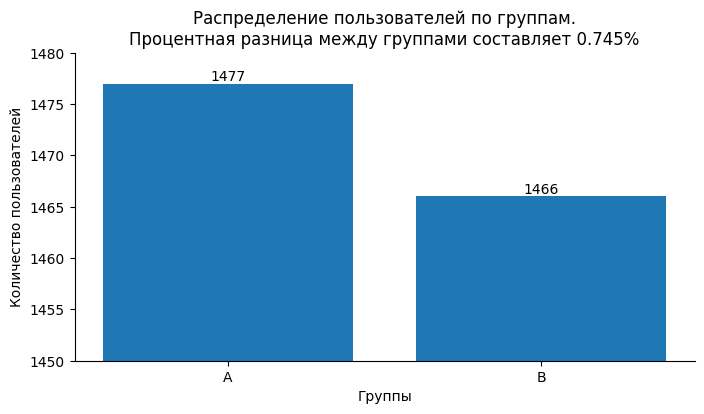

In [33]:
# Задаем область и оси
fig, ax = plt.subplots(figsize=(8, 4))

# Строим столбчатую диаграмму
ax.bar(sessions_test_part_agg.index, sessions_test_part_agg['user_count_uniq'])

# Ограничиваем оси Y
plt.ylim(1450, 1480)

# Задаем название и подписываем оси
ax.set_title(f'Распределение пользователей по группам.\nПроцентная разница между группами составляет {round(percentage_difference,3)}%')
ax.set_xlabel('Группы')
ax.set_ylabel('Количество пользователей')

# Убираем границы
ax.spines[['top', 'right']].set_visible(False)

# Подписываем бары
plt.bar_label(ax.containers[0])

# Отображаем график
plt.show()

Распределение близко к идеальному: разница между группами составляет менее процента, а именно 0,745%. Важно контролировать, чтобы отклонение не увеличивалось со временем.

### Проверка пересечений пользователей
Проверим, что группы А и В - независимы. Для этого убедимся, что никто из пользователей случайно не попал в обе группы одновременно. Используем пересечение множеств для нахождения общих элементов:

In [34]:
# Найдем множество пользователей для каждой группы
set_a = set(sessions_test_part['user_id'][sessions_test_part['test_group'] == 'A'])
set_b = set(sessions_test_part['user_id'][sessions_test_part['test_group'] == 'B'])

# Найдем пересечение  множеств
set_a.intersection(set_b)

set()

Пересечение множеств пользователей пусто, то есть нет ни одного пользователи, попавшего одновременно в группу А и группу В.

### Проверка равномерности разделения пользователей по категориям
Проверим, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

#### Проверка равномерности разделения пользователей по устройствам

Проверим, что пользователи равномерно распределены по всем типам устройства. Для этого  сгруппируем данные по `device` и `test_group` и посчитаем количество уникальных пользователей в каждой группе:

In [35]:
# Группируем и агрегируем данные
df_group_device = sessions_test_part.groupby(['device', 'test_group'])['user_id'].nunique().unstack(fill_value=0)

# Преобразовываем в проценты и округляем
df_group_device = (100 * df_group_device / sessions_test_part['user_id'].nunique()).round(2)

# Выводим результат
df_group_device

test_group,A,B
device,,
Android,22.29,22.70
Mac,5.30,5.03
PC,12.54,12.95
iPhone,10.06,9.14


In [36]:
# Добавляем столбец с разницей между группами А и В
df_group_device['delta'] = df_group_device['A'] - df_group_device['B']

# Проверяем результат
df_group_device

test_group,A,B,delta
device,,,
Android,22.29,22.70,-0.41
Mac,5.30,5.03,0.27
PC,12.54,12.95,-0.41
iPhone,10.06,9.14,0.92


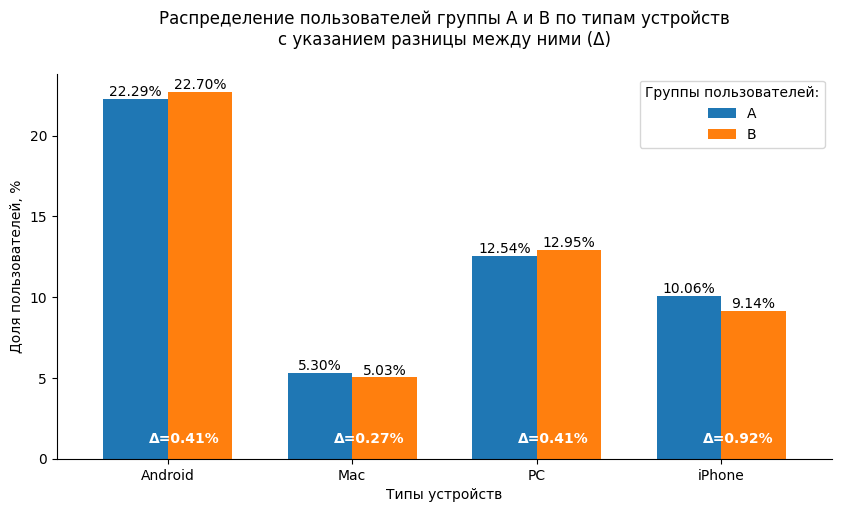

In [37]:
# Строим столбчатую диаграмму
graf_group_device = df_group_device[['A', 'B']].plot.bar(
    title=f'Распределение пользователей группы А и В по типам устройств\nс указанием разницы между ними (Δ)\n',
    xlabel='Типы устройств', ylabel='Доля пользователей, %', legend=True, figsize=(10, 5), width=0.7, rot=0
)

# Убираем границы
graf_group_device.spines[['top', 'right']].set_visible(False)

# Добавляем заголовок легенды
plt.legend(title='Группы пользователей:')

#Задаем переменные
android_delta = round(fabs(df_group_device.loc['Android','delta']), 2)
mac_delta = round(fabs(df_group_device.loc['Mac','delta']), 2)
pc_delta = round(fabs(df_group_device.loc['PC','delta']), 2)
iphone_delta = round(fabs(df_group_device.loc['iPhone','delta']), 2)

# Добавляем текст со значением разницы между группами
plt.text(-0.1, 1, f'Δ={android_delta}%', color='w', fontweight='bold')
plt.text(0.9, 1, f'Δ={mac_delta}%', color='w', fontweight='bold')
plt.text(1.9, 1, f'Δ={pc_delta}%', color='w', fontweight='bold')
plt.text(2.9, 1, f'Δ={iphone_delta}%', color='w', fontweight='bold')


# Подписываем бары
plt.bar_label(graf_group_device.containers[0], fmt='%.2f%%')
plt.bar_label(graf_group_device.containers[1], fmt='%.2f%%')

# Отображаем график
plt.show()

Проверим независимость двух категориальных переменных:

In [38]:
# Уровень значимости
alpha = 0.05

# Создаем таблицу сопряженности: группы * регионы
contingency_table = df_group_device[['A', 'B']].T
print("Таблица сопряженности:\n\n", contingency_table)

# Хи-квадрат тест на независимость
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Выводим результат
print('\nПроверка по типам устройств:')
if p_value > alpha:
    print(f'p-value={p_value:.4f} > {alpha}')
    print('Распределение между группами корректно!')
else:
    print(f'p-value={p_value:.4f} < {alpha}')
    print('⚠️Есть статистически значимый дисбаланс!')

Таблица сопряженности:

 device      Android   Mac     PC  iPhone
test_group                              
A             22.29  5.30  12.54   10.06
B             22.70  5.03  12.95    9.14

Проверка по типам устройств:
p-value=0.9962 > 0.05
Распределение между группами корректно!


Разница между группами не превышает одного процента (от 0,27% до 0,92%). Пользователи корректно распределены группам и типам устройств. Значимых перекосов не наблюдается. Группы A и B сопоставимы по типам устройств.

#### Проверка равномерности распределения пользователей по регионам

Аналогично проверим равномерность распределения пользователей по регионам:

In [39]:
# Группируем и агрегируем данные
df_group_region = sessions_test_part.groupby(['region', 'test_group'])['user_id'].nunique().unstack(fill_value=0)

# Преобразовываем в проценты и округляем
df_group_region = round(100 * df_group_region / sessions_test_part['user_id'].nunique(), 2)

# Проверяем результат
df_group_region

test_group,A,B
region,,
CIS,21.88,21.92
EU,7.61,7.37
MENA,20.69,20.52


In [40]:
# Добавляем столбец с разницей между группой А и В
df_group_region['delta'] = df_group_region['B'] - df_group_region['A']

# Проверяем результат
df_group_region

test_group,A,B,delta
region,,,
CIS,21.88,21.92,0.04
EU,7.61,7.37,-0.24
MENA,20.69,20.52,-0.17


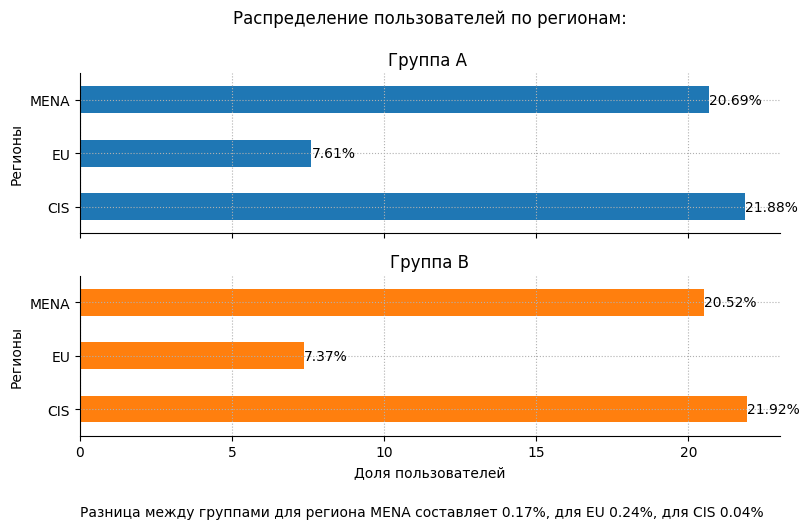

In [41]:
# Строим горизонтальную столбчатую диаграмму
graf_region = df_group_region[['A', 'B']].plot(kind='barh', subplots=True,
                                               sharex=True, figsize=(8, 5), legend=False,
                                               title = ['Распределение пользователей по регионам:\n\nГруппа А ', 'Группа В']
                                              )

# Настраиваем название и подписи осей
graf_region[0].set_ylabel('Регионы')
graf_region[1].set_ylabel('Регионы')
plt.xlabel('Доля пользователей')


# Включаем сетку для каждого из подграфиков
graf_region[0].grid(which='both', linestyle='dotted')
graf_region[1].grid(which='both', linestyle='dotted')

# Убираем границы
graf_region[0].spines[['top', 'right']].set_visible(False)
graf_region[1].spines[['top', 'right']].set_visible(False)

# Оптимизируем расположение элементов
plt.tight_layout()

# Добавим текст со значением разницы между группами
mena_delta = round(fabs(df_group_region.loc['MENA','delta']), 2)
eu_delta = round(fabs(df_group_region.loc['EU','delta']), 2)
cis_delta = round(fabs(df_group_region.loc['CIS','delta']), 2)
plt.text(0, -2, f'Разница между группами для региона MENA составляет {mena_delta}%, для EU {eu_delta}%, для CIS {cis_delta}%')

# Подписываем бары
graf_region[0].bar_label(graf_region[0].containers[0], fmt='%.2f%%')
graf_region[1].bar_label(graf_region[1].containers[0], fmt='%.2f%%')

# Отображаем график
plt.show()

Проверим независимость двух категориальных переменных:

In [42]:
# Уровень значимости
alpha = 0.05

# Создаем таблицу сопряженности: группы * регионы
contingency_table = df_group_region[['A', 'B']].T
print("Таблица сопряженности:\n\n", contingency_table)

# Хи-квадрат тест на независимость
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Выводим результат
print('\nПроверка по регионам:')
if p_value > alpha:
    print(f'p-value={p_value:.4f} > {alpha}')
    print('Распределение между группами корректно!')
else:
    print(f'p-value={p_value:.4f} < {alpha}')
    print('⚠️Есть статистически значимый дисбаланс!')

Таблица сопряженности:

 region        CIS    EU   MENA
test_group                    
A           21.88  7.61  20.69
B           21.92  7.37  20.52

Проверка по регионам:
p-value=0.9984 > 0.05
Распределение между группами корректно!


Разница между группами не превышает одного процента (от 0,04% до 0,24%). Пользователи корректно распределены. Значимых перекосов не наблюдается. Группы A и B сопоставимы по регионам.

### Вывод после мониторинга A/B-теста

Результаты мониторинга A/B-теста:

1. Независимость выборок:
   - пересечение между тестовой и контрольной группами отсутствует -  ни один пользователь не был зафиксирован одновременно в обеих группах.

2. Корректность распределения:
    - размеры групп имеют незначительное расхождение — всего 0.745%, что находится в пределах допустимой погрешности.

3. Равномерность распределения:
   - пользователи равномерно распределены по типам устройств (Android, iOS, PC, Mac);
   - пользователи равномерно распределены по группам стран (MENA, EU, CIS)

A/B-тест проводится в соблюдением правил, каких-либо нарушений и перекосов не выявлено.

## Проверка результатов A/B-теста

A/B-тест завершён, в распоряжении есть результаты за все дни проведения эксперимента. Убедимся в корректности теста и интерпретируем результаты.

### Получение результатов теста

* Загрузим и сохраните в датафрейм `sessions_test` csv-файл `sessions_project_test.csv` с данными за весь период проведения A/B-теста.

In [43]:
# Сохраняем данные в датафрейм
url3 = 'https://drive.google.com/uc?export=download&id=1UE4YH-lEUxMDVbaCyN_2V602josTeqCY'
sessions_test = pd.read_csv(url3)

* Посмотрим краткую сводку о датафрейме `sessions_test`и проверим его на наличие пропусков:

In [44]:
# Выводим информацию
sessions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            100005 non-null  object
 1   session_id         100005 non-null  object
 2   session_date       100005 non-null  object
 3   session_start_ts   100005 non-null  object
 4   install_date       100005 non-null  object
 5   session_number     100005 non-null  int64 
 6   registration_flag  100005 non-null  int64 
 7   page_counter       100005 non-null  int64 
 8   region             100005 non-null  object
 9   device             100005 non-null  object
 10  test_group         100005 non-null  object
dtypes: int64(3), object(8)
memory usage: 8.4+ MB


Данные не содержат пропусков.

* Проверим корректность числовых данных в столбцах `session_number`, `registration_flag`, `page_counter`:

In [45]:
# Выводим информацию
sessions_test.describe()

,session_number,registration_flag,page_counter
count,100005.000000,100005.000000,100005.000000
mean,2.391900,0.076396,3.023349
std,1.295824,0.265632,1.042987
min,1.000000,0.000000,1.000000
25%,1.000000,0.000000,2.000000
50%,2.000000,0.000000,3.000000
75%,3.000000,0.000000,4.000000
max,9.000000,1.000000,7.000000


Аномалий не наблюдается.

* В датафрейме `sessions_test` создадим дополнительный столбец `good_session`, который покажет, успешна или нет сессия.   Пусть в столбец войдет значение 1, если за одну сессию было просмотрено 4 и более страниц, и значение 0, если было просмотрено меньше:

In [46]:
# Создаем дубликат столбца 'page_counter'
sessions_test['good_session'] = sessions_test['page_counter']

# Применяем к столбцу метод .mask() и заменяем значения в нем на 0 или 1 при выполнении условий
sessions_test['good_session'] = sessions_test['good_session'].mask(sessions_test['good_session']<4, 0)
sessions_test['good_session'] = sessions_test['good_session'].mask(sessions_test['good_session']>=4, 1)


### Проверка корректности результатов теста
Проверим, что тест проведён корректно и группы сопоставимы. При этом важно контролировать две составляющие: и распределения пользователей по группам
и распределения сессий по группам.

#### Проверим, что в данных учитывается только первая сессия пользователей за день

* Проверим, есть ли пользователи с количеством сессий в день больше 1. Для этого сгруппируем данные по `user_id` и `session_date` и найдем количество сессий. Далее найдем сумму истинных значений, если число сессий > 1: 

In [47]:
# Группируем и агрегируем данные
# Проверяем условие и подсчитываем истинные значения
(sessions_test.groupby(['user_id', 'session_date']).agg({'session_id':'count'}) > 1).sum()

session_id    245
dtype: int64

⚠️ <u>В данных присутствуют 245 пользователей с несколькими сессиями в день!</u>  

* Получим идентификаторы этих пользователей и даты. Для этого сгруппируем данные таблицы `sessions_test` по полям `user_id` и `session_date`, для каждой группы найдем количество сессий `session_id` и с помощью `query()` оставим записи с числом сессий больше 1:

In [48]:
# Группируем и агрегируем данные
user_duplicat = sessions_test.groupby(['user_id', 'session_date'], as_index=False).agg({'session_id':'count'}).query('session_id > 1')

# Меняем имя столбца на более подходящее
user_duplicat.columns.values[2] = 'count_sessions'

# выводим таблицу
user_duplicat

,user_id,session_date,count_sessions
917,024817D675AECE70,2025-11-01,7
1012,0287649F4C8B36A4,2025-11-01,7
1083,02A8F7EE472C94D5,2025-10-14,6
1379,03557FA66351298A,2025-10-14,4
1823,048B830142BD9EBF,2025-10-17,7
...,...,...,...
97476,FBAB358739E60963,2025-10-29,2
97758,FC6E828AC08F4AEA,2025-10-22,7
98318,FDF95C769A11F3A7,2025-10-29,7
98321,FDF9FB3CF5ACD148,2025-10-14,7


* Изучим все данные таблицы `sessions_test` для одного пользователя c несколькими сессиями в один день, например, для первого пользователя из `user_duplicat`:

In [49]:
# Получаем данные для 1 пользователя за 1 день
sessions_test[(sessions_test['user_id'] == user_duplicat.iloc[0, 0]) & \
              (sessions_test['session_date'] == user_duplicat.iloc[0, 1])].sort_values(by='session_number')

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
66606,024817D675AECE70,7039FBB66A21CDB6,2025-11-01,2025-11-01 21:34:04,2025-10-17,1,0,3,MENA,Mac,B,0
34174,024817D675AECE70,194B02763BDCED9F,2025-11-01,2025-11-01 05:01:05,2025-10-17,2,0,7,MENA,Mac,B,1
8169,024817D675AECE70,A5A3EE1EE693A8D0,2025-11-01,2025-11-01 19:33:37,2025-10-17,3,0,4,MENA,Mac,B,1
32110,024817D675AECE70,8B6FD0BCFEDE4110,2025-11-01,2025-11-01 12:16:31,2025-10-17,4,0,6,MENA,Mac,B,1
70472,024817D675AECE70,FF778CE5C77306DD,2025-11-01,2025-11-01 17:10:55,2025-10-17,5,0,3,MENA,Mac,B,0
97935,024817D675AECE70,63FAE096CE68B039,2025-11-01,2025-11-01 11:30:21,2025-10-17,6,0,5,MENA,Mac,B,1
91732,024817D675AECE70,B0BAAA36CBB8E7C6,2025-11-01,2025-11-01 21:11:24,2025-10-17,7,0,6,MENA,Mac,B,1


Обратим внимание, что нумерация сессий не соответствует реальному времени их начала, например, сессия № 1 началась гораздо позже (в 21:34), чем сессия № 2 (05:01). Вероятно номер сессии формируется не по времени, а в порядке регистрации её в базе данных. Таким образом, использовать номер сессий для их фильтрации нельзя.

* В таблице `sessions_test` оставим только по одной сессии для пользователя в день.  Для пользователей с несколькими сессиями в день - оставим только первые, при этом первой сессией будем считать более ранюю по времени.

Отсортируем данные по идентификатору пользователя `user_id`, по дате сессии `session_date` и по старту сеcсии `session_start_ts` в порядке возрастания, чтобы более раннии сессии были первыми. Дубликатами будем считать записи с одинаковыми идентификаторами и датами. Удалим дубликаты, оставив только первые записи, то есть более раннии сессии:

In [50]:
# Сортируем данные и удаляем дубликаты
sessions_test_cleaned = sessions_test.sort_values(by=['user_id', 'session_date', 'session_start_ts']\
                                                 ).drop_duplicates(subset=['user_id','session_date'], keep='first')

Проверим результат и выведем количество пользователей с несколькими сессиями в день:

In [51]:
# Группируем и агрегируем данные
# Проверяем условие и подсчитываем истинные значения
(sessions_test_cleaned.groupby(['user_id', 'session_date']).agg({'session_id':'count'}) > 1).sum()

session_id    0
dtype: int64

Теперь данные содержат только по 1 сессии пользователя в день.

In [52]:
print('Общее число сессий в первоначальном датафрейме', sessions_test['session_id'].nunique())
print('Общее число сессий после удаления', sessions_test_cleaned['session_id'].nunique())
print('Количество удаленных сессий', sessions_test['session_id'].nunique() - sessions_test_cleaned['session_id'].nunique())


Общее число сессий в первоначальном датафрейме 100005
Общее число сессий после удаления 99171
Количество удаленных сессий 834


#### Проверим, есть ли пользователи с несколькими регионами и типами устройств:

In [53]:
# Группируем и агрегируем данные, проверяем условие и подсчитываем истинные значения
(sessions_test_cleaned.groupby(['user_id']).agg({'region':'nunique'}) > 1).sum()

region    0
dtype: int64

In [54]:
# Группируем и агрегируем данные, проверяем условие и подсчитываем истинные значения
(sessions_test_cleaned.groupby(['user_id']).agg({'device':'nunique'}) > 1).sum()

device    0
dtype: int64

За указанный период пользователи не меняли регион и тип устройства.

#### Проверка длительности эксперимента 

Определим сколько дней, согласно предоставленным данным, длился эксперимент:

In [55]:
# Находим количество уникальных дат
sessions_test_cleaned['session_date'].nunique()

20

Обратим внимание, что длительность эксперимента меньше расчетного значения в 21 день!

#### Проверка пересечений пользователей

Проверим, что никто из пользователей случайно не попал в обе группы одновременно. Для этого для каждого пользователя `user_id` найдем количество уникальных групп `test_group` и выведем пользователей с количеством групп больше 1:

In [56]:
# Группируем и агрегируем данные
sessions_test_cleaned.groupby(['user_id']).agg({'test_group':'nunique'}).query('test_group > 1')

,test_group
user_id,


Пользователей, попавших в более чем одну группу нет.

#### Проверка распределения пользователей по группам

Рассчитаем количество уникальных пользователей в каждой из групп:

In [57]:
# Группируем и агрегируем данные
sessions_test_cleaned_user = sessions_test_cleaned.groupby(['test_group']).agg({'user_id':'nunique'})

# Переименовываем столбец на более подходящее имя
sessions_test_cleaned_user.columns = ['user_count_uniq']

sessions_test_cleaned_user

,user_count_uniq
test_group,
A,15163
B,15416


Убедимся, что дисбаланс между группами (15 163 и 15 416) — это случайность, а не ошибка в распределении. Обозначим `n_a`  и `n_b` - количество пользователей в группах А и В соответственно, а `total_observed` - общее количество. Воспользуемся хи-квадрат тестом: 

In [58]:
# уровень значимости
alpha = 0.05

# Фактическое распределение
n_a = sessions_test_cleaned_user.loc['A', 'user_count_uniq']
n_b = sessions_test_cleaned_user.loc['B', 'user_count_uniq']
observed = [n_a, n_b]

# Планируемое распределение
total_observed = sessions_test_cleaned_user['user_count_uniq'].sum()
expected = [total_observed / 2, total_observed / 2]

chi2, p_value_chi2 = chisquare(observed, f_exp=expected)

if p_value_chi2 > alpha:
    print(f'p-value={p_value_chi2:.4f} > {alpha}')
    print('Нулевая гипотеза находит подтверждение - разница между группами незначима! Дисбаланс - это случайность')
else:
    print(f'p-value={p_value_chi2:.4f} < {alpha}')
    print('⚠️Нулевая гипотеза не находит подтверждения - разница между группами значима!')

p-value=0.1480 > 0.05
Нулевая гипотеза находит подтверждение - разница между группами незначима! Дисбаланс - это случайность


####  Проверим корректность разбиения пользователей по регионам:

In [59]:
# Группируем и агрегируем данные
sessions_test_cleaned_region = sessions_test_cleaned.groupby(['region', 'test_group'])['user_id'].nunique().unstack(fill_value=0)

# Посмотрим на таблицу
sessions_test_cleaned_region

test_group,A,B
region,,
CIS,6790,6858
EU,2373,2369
MENA,6000,6189


Используем критерий Пирсона для проверки независимости двух категориальных переменных:

In [60]:
# Уровень значимости
alpha = 0.05

# Создаем таблицу сопряженности: группы * регионы
contingency_table = sessions_test_cleaned_region.T
print("Таблица сопряженности:\n\n", contingency_table)

# Хи-квадрат тест на независимость
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Выводим результат
print('\nПроверка по регионам:')
if p_value_chi2 > alpha:
    print(f'p-value={p_value:.4f} > {alpha}')
    print('Распределение между группами корректно, распределение пользователей по группам не зависит от региона!')
else:
    print(f'p-value={p_value:.4f} < {alpha}')
    print('⚠️Есть статистически значимый дисбаланс. Регионы влияют на распределение между группами!')

Таблица сопряженности:

 region       CIS    EU  MENA
test_group                  
A           6790  2373  6000
B           6858  2369  6189

Проверка по регионам:
p-value=0.5544 > 0.05
Распределение между группами корректно, распределение пользователей по группам не зависит от региона!


#### Проверим корректность разбиения пользователей по типам устройств:

In [61]:
# Группируем и агрегируем данные
sessions_test_cleaned_device = sessions_test_cleaned.groupby(['device', 'test_group'])['user_id'].nunique().unstack(fill_value=0)

# Посмотрим на таблицу
sessions_test_cleaned_device

test_group,A,B
device,,
Android,6796,6982
Mac,1502,1541
PC,3830,3849
iPhone,3035,3044


Проверим независимость двух категориальных переменных:

In [62]:
# Уровень значимости
alpha = 0.05

# Создаем таблицу сопряженности: группы * регионы
contingency_table = sessions_test_cleaned_device.T
print("Таблица сопряженности:\n\n", contingency_table)

# Хи-квадрат тест на независимость
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Выводим результат
print('\nПроверка по типам устройств:')
if p_value_chi2 > alpha:
    print(f'p-value={p_value:.4f} > {alpha}')
    print('Распределение между группами корректно, распределение пользователей по группам не зависит от типа устройства!')
else:
    print(f'p-value={p_value:.4f} < {alpha}')
    print('⚠️Есть статистически значимый дисбаланс. Тип устройства влияет на распределение между группами!')

Таблица сопряженности:

 device      Android   Mac    PC  iPhone
test_group                             
A              6796  1502  3830    3035
B              6982  1541  3849    3044

Проверка по типам устройств:
p-value=0.8066 > 0.05
Распределение между группами корректно, распределение пользователей по группам не зависит от типа устройства!


#### Проверим распределение сессий по тестовым группам.

Рассчитаем количество сессий в каждой из групп:

In [63]:
# Группируем и агрегируем данные
sessions_test_cleaned_sessions = sessions_test_cleaned.groupby(['test_group']).agg({'session_id':'nunique'})

# Переименовываем столбец на более подходящее имя
sessions_test_cleaned_sessions.columns = ['sessions_count']

sessions_test_cleaned_sessions

,sessions_count
test_group,
A,49242
B,49929


In [64]:
print(f'Разница между группами: {sessions_test_cleaned_sessions.loc['B', 'sessions_count'] - sessions_test_cleaned_sessions.loc['A', 'sessions_count']}')

Разница между группами: 687


Убедимся, что дисбаланс между группами  — это случайность, а не ошибка в распределении. Воспользуемся хи-квадрат тестом: 

In [65]:
alpha = 0.05

# Фактическое распределение
observed = [sessions_test_cleaned_sessions.loc['A', 'sessions_count'], sessions_test_cleaned_sessions.loc['B', 'sessions_count']]
total_observed = sessions_test_cleaned_sessions['sessions_count'].sum()

# Планируемое распределение
expected = [total_observed / 2, total_observed / 2]

chi2, p_value_chi2 = chisquare(observed, expected)

if p_value_chi2 > alpha:
    print(f'p-value={p_value_chi2:.4f} > {alpha}')
    print('Нулевая гипотеза находит подтверждение - разница между группами незначима!')
else:
    print(f'p-value={p_value_chi2:.4f} < {alpha}')
    print('⚠️Нулевая гипотеза не находит подтверждения - разница между группами значима!')

p-value=0.0291 < 0.05
⚠️Нулевая гипотеза не находит подтверждения - разница между группами значима!


Тест показал, что разница в количестве сессий между группами (687 сессий) статистически значима. Рассчитаем процентную разницу между группами:

In [66]:
# Подготовим данные
count_sessions_a = sessions_test_cleaned_sessions.loc['A', 'sessions_count']
count_sessions_b = sessions_test_cleaned_sessions.loc['B', 'sessions_count']
# Производим расчет
percentage_difference = 100 * fabs(count_sessions_a - count_sessions_b) / count_sessions_a
# Выводим результат
print(f'Процентная разница в количестве сессий в группах A и B: {round(percentage_difference,3)}%')

Процентная разница в количестве сессий в группах A и B: 1.395%


#### Проверим распределение сессий по регионам

In [67]:
# Группируем и агрегируем данные
sessions_test_cleaned_region = sessions_test_cleaned.groupby(['region', 'test_group'])['session_id'].nunique().unstack(fill_value=0)

# Посмотрим на таблицу
sessions_test_cleaned_region

test_group,A,B
region,,
CIS,22025,22302
EU,7696,7672
MENA,19521,19955


Используем критерий Пирсона для проверки независимости двух категориальных переменных:

In [68]:
# Уровень значимости
alpha = 0.05

# Создаем таблицу сопряженности: группы * регионы
contingency_table = sessions_test_cleaned_region.T
print("Таблица сопряженности:\n\n", contingency_table)

# Хи-квадрат тест на независимость
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Выводим результат
print('\nПроверка по регионам:')
if p_value > alpha:
    print(f'p-value={p_value:.4f} > {alpha}')
    print('Распределение между группами корректно, распределение сессий по группам не зависит от региона!')
else:
    print(f'p-value={p_value:.4f} < {alpha}')
    print('⚠️Есть статистически значимый дисбаланс. Регионы влияют на распределение между группами!')

Таблица сопряженности:

 region        CIS    EU   MENA
test_group                    
A           22025  7696  19521
B           22302  7672  19955

Проверка по регионам:
p-value=0.4105 > 0.05
Распределение между группами корректно, распределение сессий по группам не зависит от региона!


#### Проверим корректность разбиения сессий по типам устройств:

In [69]:
# Группируем и агрегируем данные
sessions_test_cleaned_device = sessions_test_cleaned.groupby(['device', 'test_group'])['session_id'].nunique().unstack(fill_value=0)

# Посмотрим на таблицу
sessions_test_cleaned_device

test_group,A,B
device,,
Android,22062,22713
Mac,4925,4991
PC,12387,12408
iPhone,9868,9817


Используем критерий Пирсона для проверки независимости двух категориальных переменных:

In [70]:
# Уровень значимости
alpha = 0.05

# Создаем таблицу сопряженности: группы * регионы
contingency_table = sessions_test_cleaned_device.T
print("Таблица сопряженности:\n\n", contingency_table)

# Хи-квадрат тест на независимость
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Выводим результат
print('\nПроверка по регионам:')
if p_value > alpha:
    print(f'p-value={p_value:.4f} > {alpha}')
    print('Распределение между группами корректно, распределение пользователей по группам не зависит от типа устройства!')
else:
    print(f'p-value={p_value:.4f} < {alpha}')
    print('⚠️Есть статистически значимый дисбаланс. Тип устройства влияет на распределение между группами!')

Таблица сопряженности:

 device      Android   Mac     PC  iPhone
test_group                              
A             22062  4925  12387    9868
B             22713  4991  12408    9817

Проверка по регионам:
p-value=0.1514 > 0.05
Распределение между группами корректно, распределение пользователей по группам не зависит от типа устройства!


#### Распределение количества сессий для каждого дня и обеих тестовых групп.

* Подготовим данные и сохраним в `sessions_test_cleaned_agg` количество сессий за каждый день для каждой тестовой группы:

In [71]:
# Группируем и агрегируем данные
sessions_test_cleaned_agg = sessions_test_cleaned.groupby(['session_date','test_group']).agg({'session_id':'nunique'}).unstack(fill_value=0)

# Выводим результат
sessions_test_cleaned_agg

session_id      
test_group            A     B
session_date                 
2025-10-14         1477  1466
2025-10-15         2220  2262
2025-10-16         3255  3214
2025-10-17         4070  4028
2025-10-18         4999  5038
2025-10-19         6532  6763
2025-10-20         5822  6076
2025-10-21         3919  3972
2025-10-22         3062  3093
2025-10-23         2459  2529
2025-10-24         2082  2064
2025-10-25         1888  1797
2025-10-26         1658  1678
2025-10-27         1449  1486
2025-10-28         1258  1270
2025-10-29         1053  1104
2025-10-30          871   863
2025-10-31          622   639
2025-11-01          408   447
2025-11-02          138   140

In [72]:
# Удалим нулевой уровень индексов строк
sessions_test_cleaned_agg = sessions_test_cleaned_agg.droplevel(0, axis=1)
sessions_test_cleaned_agg

test_group,A,B
session_date,,
2025-10-14,1477,1466
2025-10-15,2220,2262
2025-10-16,3255,3214
2025-10-17,4070,4028
2025-10-18,4999,5038
2025-10-19,6532,6763
2025-10-20,5822,6076
2025-10-21,3919,3972
2025-10-22,3062,3093


* Построим визуализацию для каждой группы:

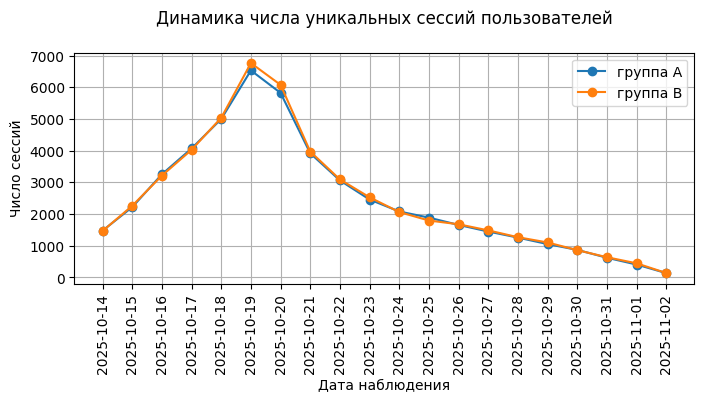

In [73]:
# Зададим размер фигуры
plt.figure(figsize=(8,3))

# Строим линейный график
plt.plot(sessions_test_cleaned_agg, marker='o', label=['группа A', 'группа B'])

# Отображаем легенду
plt.legend()

# Настраиваем название и подписи осей
plt.title('Динамика числа уникальных сессий пользователей\n')
plt.xlabel('Дата наблюдения')
plt.ylabel('Число сессий')

#
plt.xticks(sessions_test_cleaned_agg.index, rotation=90)
 
# Добавим сетку
plt.grid()

# Отображаем график
plt.show()

Наблюдается рост и падение числа сессий в обеих группах. Рост числа сессий вероятно говорит о проведенно маркетинговой акции. Метрики демонстрирует одинаковую динамику.

#### Вывод

- Датафрейм `sessions_test_cleaned` содержит информацию по одной сессии в день для каждого пользователя, при этом каждый пользователь относится только к одному региону и имеет один тип устройства.
- Длительность эксперимента составляет не полные 3 недели - 20 дней.
- Группы не пересекаются по пользователям. Пользователи корректно распределены по группам: сбалансированы по типам устройств и регионам.
- Размеры групп больше запланированного объема (17441) примерно в 3 раза: группа А - 49242 наблюдения, группа В - 49929. 
- Между группами А и В существует разница в распределении сессий (687 сессий) и она, согласно тесту, статистически значима. Эта разница не связана с регионом проживания пользователей и с типами устройств. Однако график динамики числа сессий по дням показывает внешнее воздействие на обе группы пользователей в течение эксперимента, что могло искусственно увеличить число сессий. Фактический прирост числа сессий в группе В составил всего 1,395% - незначительный с практической точки зрения.

### Анализ ключевых метрик

#### Сравнение доли успешных сессий

Анализ ключевой метрики — доли успешных сессий.  

Рассчитаем долю успешных сессий `good_session` для выборок A и B, а также разницу в этом показателе:

In [74]:
# Расчитаем долю успешных сессий
sessions_test_cleaned_good_session = sessions_test_cleaned.groupby('test_group')['good_session'].value_counts(normalize=True).unstack(fill_value=0).T
sessions_test_cleaned_good_session

test_group,A,B
good_session,,
0,0.692965,0.686635
1,0.307035,0.313365


In [75]:
# Удаляем строку с неуспешными сессиями
sessions_test_cleaned_good_session = sessions_test_cleaned_good_session.drop([0], axis=0)

In [76]:
# Переведем в проценты
sessions_test_cleaned_good_session = round(sessions_test_cleaned_good_session * 100, 3)
sessions_test_cleaned_good_session

test_group,A,B
good_session,,
1,30.703,31.336


In [77]:
# Расчитаем разницу долей успешных сессий
sessions_test_cleaned_good_session['delta'] = (sessions_test_cleaned_good_session['B'] - sessions_test_cleaned_good_session['A']).round(2)
display(sessions_test_cleaned_good_session)

good_session_a = sessions_test_cleaned_good_session.loc[1, 'A']
good_session_b = sessions_test_cleaned_good_session.loc[1, 'B']
good_session_delta = sessions_test_cleaned_good_session.loc[1, 'delta']

print(f'Доля успешных сессий группы А: {good_session_a}%')
print(f'Доля успешных сессий группы B: {good_session_b}%')
print(f'Разница в долях (delta) групп А и В  : {good_session_delta}%')

# Производим расчет
percentage_difference = 100 * fabs(good_session_a - good_session_b) / good_session_a
# Выводим результат
print(f'Процентная разница в количестве успешных сессий в группах A и B: {round(percentage_difference,3)}%')

test_group,A,B,delta
good_session,,,
1,30.703,31.336,0.63


Доля успешных сессий группы А: 30.703%
Доля успешных сессий группы B: 31.336%
Разница в долях (delta) групп А и В  : 0.63%
Процентная разница в количестве успешных сессий в группах A и B: 2.062%


#### Проверка статистической значимости изменения ключевой метрики

Согласно расчетов, количество успешных сессий в тестовой выборке примерно на 0.63% выше, чем в контрольной, однако делать выводы только на основе этого значения будет некорректно. Для принятия решения проверим, является ли это изменение статистически значимым.

Сформулируем гипотезу: доля успешных сессий после внедрения нового алгоритма рекомендаций увеличится. В качестве основной метрики выбираем долю успешных сессий.  

Обозначим за {рA,рB} доли успешных сессий в группах A и B. Тогда гипотезы будут выглядеть так:
- H0: рА >= рВ  
- H1: рА < рВ

Гипотеза касается долевых метрики, поэтому будем использовать z-тест пропорций:

* Проверим, выполняется ли предпосылка Z-теста пропорций о достаточном размере выборок. Для этого посчитаем количество сессий в каждой группе и количество успешных сессий в них.

In [78]:
# Найдем размер выборок
n_a = sessions_test_cleaned[sessions_test_cleaned['test_group'] == 'A'].shape[0]
n_b = sessions_test_cleaned[sessions_test_cleaned['test_group'] == 'B'].shape[0]

# Найдем количество успешных сессий
m_a = sessions_test_cleaned[(sessions_test_cleaned['test_group'] == 'A') & (sessions_test_cleaned['good_session'] == True)].shape[0]
m_b = sessions_test_cleaned[(sessions_test_cleaned['test_group'] == 'B') & (sessions_test_cleaned['good_session'] == True)].shape[0]

# Рассчитаем доли успехов для каждой группы 
p_a = m_a/n_a
p_b = m_b/n_b 


print(f'Число сессий n_a={n_a}, n_b={n_b}')
print(f'Число успешных сессий m_a={m_a}, m_b={m_b}')
print(f'Доли успехов p_a={p_a}, p_b={p_b}')

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('⚠️Предпосылка о достаточном количестве данных НЕ выполняется!')

Число сессий n_a=49242, n_b=49929
Число успешных сессий m_a=15119, m_b=15646
Доли успехов p_a=0.3070346452215588, p_b=0.31336497826914217
Предпосылка о достаточном количестве данных выполняется!


* Рассчитаем размер эффекта - индекс Cohen's h для сравнения двух пропорций:  

In [79]:
# Уровень значимости
alpha = 0.05

# Считаем размер эффекта
effect_size = proportion_effectsize(p_a, p_b)

print(f"Размер эффекта Cohen's h: {(effect_size):.6f}")

Размер эффекта Cohen's h: -0.013685


Знак указывает, что эффект в группе В лучше, однако он крайне мал |0.014| < 0.2

* Рассчитаем фактическую мощность:

In [80]:
# Cчитаем соотношение размеров групп
ratio = n_b / n_a

# Считаем фактическую мошность
power = zt_ind_solve_power(
    effect_size=effect_size,
    nobs1=n_a,  
    alpha=alpha,
    ratio=ratio
)

print(f"Мощность теста: {power:.2f}")

Мощность теста: 0.58


Несмотря на большие выборки, мощность теста недостаточна. Вероятность обнаружить разницу, если она есть, составляет 58%

* Применяем Z-тест пропорций для проверки гипотезы:

In [81]:
stat_ztest, p_value_ztest = proportions_ztest([m_a, m_b], [n_a, n_b], alternative='smaller')

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}') 
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('⚠️Нулевая гипотеза не находит подтверждения!')

pvalue=0.01559250114478942 < 0.05
⚠️Нулевая гипотеза не находит подтверждения!


Изменение количества успешных сессий в тестовой выборке на + 0.63%, чем в контрольной, является статистически значимым.

### Вывод по результатам A/B-эксперимента

1).В рамках эксперимента проверялась гипотеза о положительном влиянии нового алгоритма рекомендации на вовлеченность пользователей. Ключевая метрика: доля успешных сессий, т.е. сессий в рамках которых было просмотрено 4 или более страниц контента.
        
2).Дизайн эксперимента:
- уровень значимости в эксперименте был выбран на уровне 5% ;
- планируемая мощность теста - 80%;
- минимальный детектируемый эффект - 3%;
- расчетный размер выборок- 17441 наблюдений для каждой группы;
- планируемая длительность эксперимента 3 недели

3).Аудитория:
   - в эксперименте участвуют пользователи 3 регионов: CIS, EU и MENA
   - 4 типа устройств: Android, Mac, PC и iPhone.
     
4).Фактическая длительность:
 - эксперимент проводился на протяжении не полных трех недель -  20 дней: с 2025-10-14 (вторник) по 2025-11-02 (воскресенье).
     
5).Фактический размер групп:
  - размеры групп больше запланированного объема примерно в 3 раза:  
    группа А - 49242 наблюдения,  
    группа В - 49929.
  - между группами существует статистически значимая разница: + 687 сессий в группе В. 

В результате проведенного анализы было выявлено:
- внедрение нового алгоритма рекомендаций статистически значимо (полученное значение pvalue=0.0156) улучшило метрику на 0.63% (относительный прирост составил +2.06% к базовой конверсии). Но размер эффекта Cohen’s крайнне мал (0.0137) и изменение метрики не достигает запланированного MDE в 3% , что указывает на сомнительную практическую значимость - внедрение может не окупить затраты;
- в процессе эксперимента наблюдалось внешнее воздействие на обе группы пользователей, что могло искусственно увеличить число сессий и исказить результаты;
- не смотря на большие объемы выборок, мощность теста составляет 58% и недостаточна для надежных выводов.

Таким образом, результаты не позволяют сделать однозначный вывод о преимуществах нового алгоритма. Полагаться на результаты эксперимента и внедрять новый алгоритм рекомендаций стоит крайне осторожно. При высоких затратах на нововведение эффект может не окупиться. Рекомендую провести дополнительные исследования и проверить эффект на подгруппах (по регионам и типам устройств) или проверить эффект на новых данных, предварительно устранив влияние внешних факторов, и повысить мощность теста путем увеличения выборки или длительности эксперимента.

------